In [1]:
import os
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns

os.chdir('C:\\Users\mil_kry\Desktop')

df = pd.read_csv('winequality-red.csv')

# clean the dataset 
lst = []
for i in range(len(df)):
    lst.append(df.iloc[:,0][i].split(';'))
    
columns = df.columns[0].split(';')
columns = [i.replace('"','') for i in columns]
df = pd.DataFrame(lst, columns = columns)
df[columns] = df[columns].apply(pd.to_numeric)
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


<AxesSubplot:>

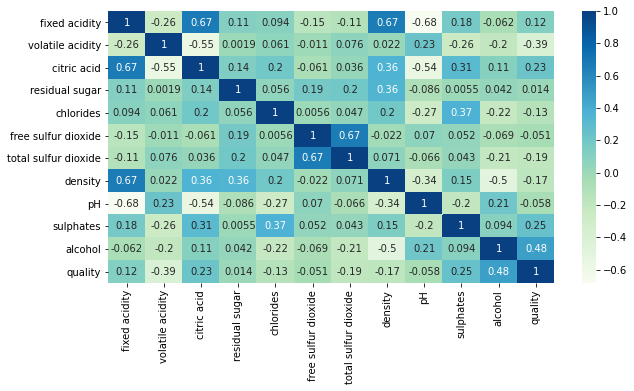

In [2]:
plt.figure(figsize=(10,5))
df_corr = df.corr()
sns.heatmap(df_corr, annot=True, cmap="GnBu")

In [3]:
# split wine into good and bad ones
def split_quality(data):
    if data.quality >= 6.5:
        data['class'] = 'good'
    else:
        data['class'] = 'bad'
    return data

df_class = df.apply(split_quality,axis=1).drop('quality',axis=1)

In [4]:
labels = df_class['class'].unique().tolist()
sizes = df_class['class'].value_counts().tolist()
colors = ["#59CBC0", "#BFD7D4"]

Text(0.5, 1.0, 'Quality Distribution')

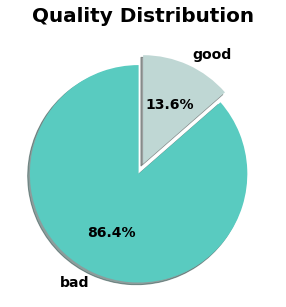

In [5]:
plt.figure(figsize = (10,5))
plt.pie(sizes, labels=labels, colors=colors, explode=(0.1,0), 
        autopct='%1.1f%%',startangle=90,shadow=True,
        textprops={'fontsize': 14, "fontweight" : "bold"})
plt.title('Quality Distribution', size=20, fontweight='bold')

In [6]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler

le = LabelEncoder() 
# 0: bad, 1: good
df_class['class'] = le.fit_transform(df_class['class'])

In [7]:
# separate features and classes
x = df_class.iloc[:,:-1]
y = df_class.iloc[:,-1]

In [8]:
# train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3,random_state=42)

In [9]:
# models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

# metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, precision_score


In [10]:
# fit using a logistic regression classifier
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

C:\Users\mil_kry\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [11]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.97      0.93       413
           1       0.56      0.21      0.30        67

    accuracy                           0.87       480
   macro avg       0.72      0.59      0.62       480
weighted avg       0.84      0.87      0.84       480



Even though the total accuracy is 0.87, which doesn't sound bad, observe that the metrics for good quality wine are poor. This is because the dataset is imbalanced and so accuracy would largely be determined by the dominant class. Thus if we are more interested in identifying good quality wine, this model is terrible. We need to find a way to increase the precision and recall for good quality wine.

In [12]:
# let's deal with the imbalanced dataset using SMOTE
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)

X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

In [13]:
# SMOTE creates sample for the minority class
print(y_train.value_counts())
print(y_train_res.value_counts())

0    969
1    150
Name: class, dtype: int64
1    969
0    969
Name: class, dtype: int64


In [14]:
# now logistic regression again
lr2 = LogisticRegression()
lr2.fit(X_train_res, y_train_res)
y_predict_lr2 = lr2.predict(X_test)
print("Accuracy Score :",lr2.score(X_test, y_test))

Accuracy Score : 0.8104166666666667


C:\Users\mil_kry\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [15]:
# see the difference in precision and recall. 
print(classification_report(y_test, y_predict_lr2))

              precision    recall  f1-score   support

           0       0.96      0.81      0.88       413
           1       0.41      0.81      0.54        67

    accuracy                           0.81       480
   macro avg       0.69      0.81      0.71       480
weighted avg       0.89      0.81      0.83       480



In [16]:
# now try a decision tree
dtc = DecisionTreeClassifier(criterion='gini', min_samples_split=10)
dtc.fit(X_train_res, y_train_res)
print('accuracy:', dtc.score(X_test,y_test))

y_pred_dtc = dtc.predict(X_test)
print(classification_report(y_test, y_pred_dtc))

accuracy: 0.84375
              precision    recall  f1-score   support

           0       0.94      0.88      0.91       413
           1       0.46      0.63      0.53        67

    accuracy                           0.84       480
   macro avg       0.70      0.75      0.72       480
weighted avg       0.87      0.84      0.85       480



In [17]:
# now try a Random Forest Classifier
rfc = RandomForestClassifier()
rfc.fit(X_train_res, y_train_res)
print('accuracy:', rfc.score(X_test,y_test))

y_pred_rfc = rfc.predict(X_test)
print(classification_report(y_test, y_pred_rfc))

# observe that ensemble method is doing a lot better

accuracy: 0.8791666666666667
              precision    recall  f1-score   support

           0       0.95      0.91      0.93       413
           1       0.55      0.70      0.62        67

    accuracy                           0.88       480
   macro avg       0.75      0.80      0.77       480
weighted avg       0.89      0.88      0.88       480

